<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/examples/solar_energy_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Source API - https://www.solar.sheffield.ac.uk/

### Sheffield Solar collects solar generation data from over 6000 PV installations all across the UK from both domestic and commercial sources. 

# Solar Data API

In [1]:
## install required libraries

#! pip install git+https://github.com/statsmodels/statsmodels.git
! pip install tsextract

import numpy as np
import pandas as pd
import statsmodels.api as sm


from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


! pip install --upgrade git+https://github.com/SheffieldSolar/PV_Live-API

from pvlive_api import PVLive
from datetime import datetime
import pytz


from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std
from tsextract.plots.eval import actualPred, get_lag_corr, scatter

from sklearn.preprocessing import StandardScaler



from plotnine import *
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense, Dropout

  Cloning https://github.com/SheffieldSolar/PV_Live-API to /tmp/pip-req-build-458yflc9
  Running command git clone -q https://github.com/SheffieldSolar/PV_Live-API /tmp/pip-req-build-458yflc9
  Created wheel for pvlive-api: filename=pvlive_api-0.5-py2.py3-none-any.whl size=5783 sha256=0d92f74e228b8ea01745c323c8ca6548997c344fe4558a89e0ddf4496a9a51b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-drt_b6sf/wheels/46/5c/ae/b7f2533e8d907b10cfcf5bf293178ed0e97251c0050576f2a7
Successfully built pvlive-api
  Found existing installation: pvlive-api 0.5
    Uninstalling pvlive-api-0.5:
      Successfully uninstalled pvlive-api-0.5


In [2]:
pvl = PVLive()

years = [2014, 2015, 2016, 2017, 2018, 2019]
years = [2017, 2018, 2019]


data = []
for each in years:
  date_dt1 = pytz.utc.localize(datetime.strptime("{}-11-21T12:30:00Z".format(each), '%Y-%m-%dT%H:%M:%SZ'))
  date_dt2 = pytz.utc.localize(datetime.strptime("{}-11-21T11:30:00Z".format(each+1), '%Y-%m-%dT%H:%M:%SZ'))
  data.append(pvl.between(date_dt1, date_dt2))

In [3]:
flat_list = [halfhour for subdata in data for halfhour in subdata]

df = pd.DataFrame(flat_list, columns=["id", "date", "energy"])
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%dT%H:%M:%SZ')
df = df.drop(columns="id").set_index("date")
df = df.asfreq(freq='30T')

df = pd.DataFrame(df["energy"].ffill())

In [7]:
#df.to_csv("solar_energy.csv")
#df = pd.read_csv("solar_energy.csv")
#df = df.set_index("date")

In [33]:
df.head()

,energy
date,
2014-11-21 12:30:00,301.0
2014-11-21 13:00:00,297.0
2014-11-21 13:30:00,223.0
2014-11-21 14:00:00,171.0
2014-11-21 14:30:00,115.0


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


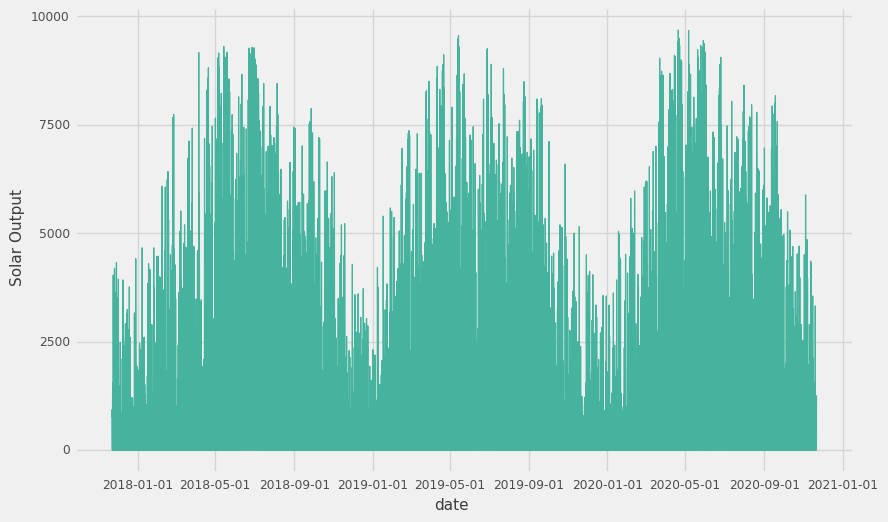

<ggplot: (-9223363297277291730)>

In [14]:
import plotnine
p = (
    ggplot(df, aes(x='df.index', y='energy'))
    + geom_line(color='#45B39D') # line plot
    + labs(x='date', y='Solar Output')
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


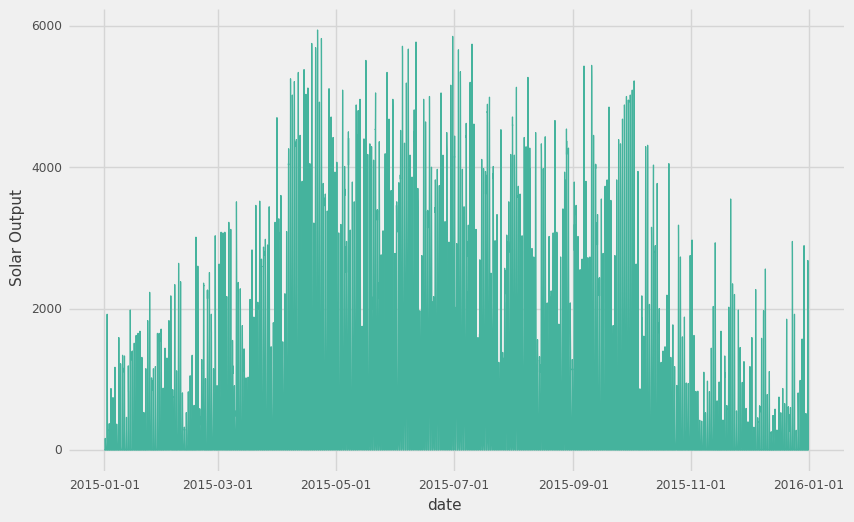

<ggplot: (-9223363285408662647)>

In [40]:
p = (
    ggplot(df[(df.index.year == 2015)], aes(x='df[(df.index.year == 2015)].index', y='energy'))
    + geom_line(color='#45B39D') # line plot
    + labs(x='date', y='Solar Output')
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p

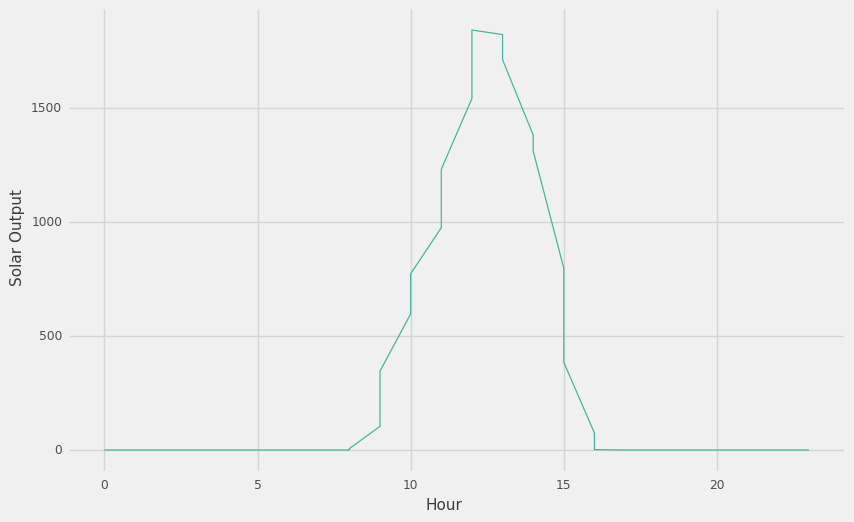

<ggplot: (8751445439261)>

In [42]:
p = (
    ggplot(df[((df.index.year == 2018) & (df.index.month == 1) & (df.index.day == 1))], aes(x='df[((df.index.year == 2018) & (df.index.month == 1) & (df.index.day == 1))].index.hour', y='energy'))
    + geom_line(color='#45B39D') # line plot
    + labs(x='Hour', y='Solar Output')
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p

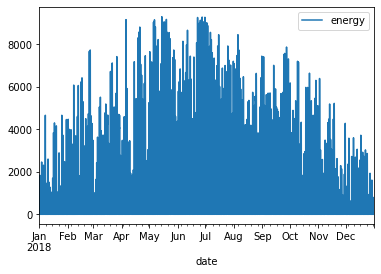

In [53]:
df[(df.index.year == 2018)].plot()

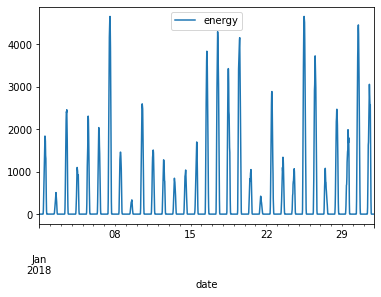

In [92]:
df[((df.index.year == 2018) & (df.index.month == 1))].plot()

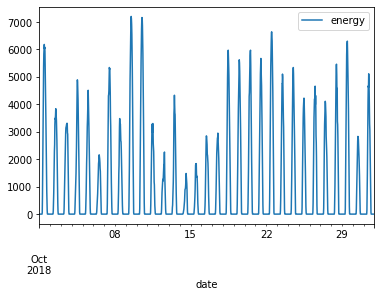

In [65]:
df[((df.index.year == 2018) & (df.index.month == 10))].plot()

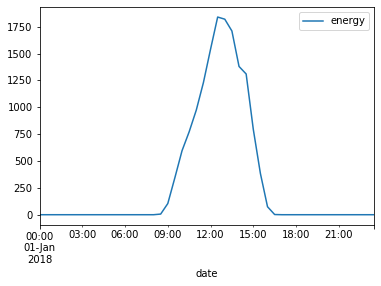

In [111]:
df[((df.index.year == 2018) & (df.index.month == 1) & (df.index.day == 1))].plot()

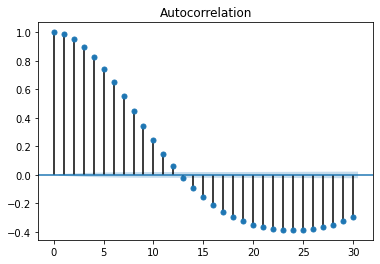

In [34]:
sm.graphics.tsa.plot_acf(df["energy"], lags=30)
plt.show()

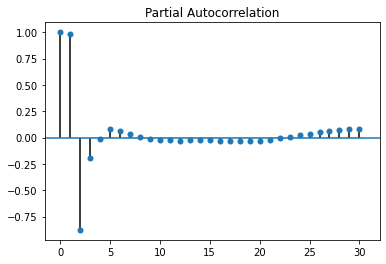

In [35]:
sm.graphics.tsa.plot_pacf(df["energy"], lags=30)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


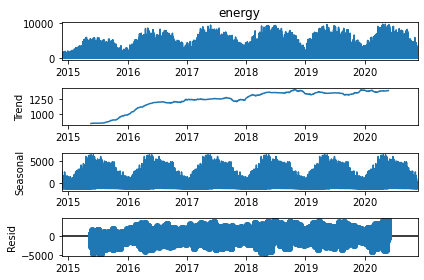

In [51]:
freq = 2*24*30*12
result = seasonal_decompose(df["energy"], model='additive', freq=freq)
result.plot()
pyplot.show()

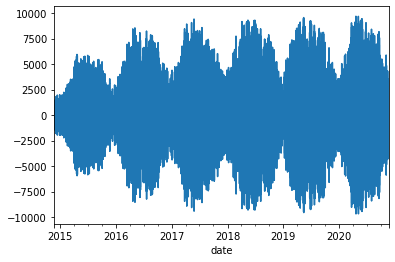

In [62]:
df["energy"].diff(24).plot()

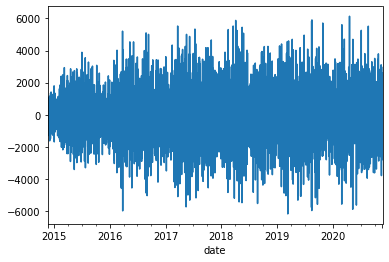

In [68]:
df["energy"].diff(48).plot()

# tsExtract

In [70]:
features_request = {
    "window": [48],
    "window_statistic": [48, mean], 
    "difference_statistic": [48, 15, std],
    "momentum_statistic": [48, 15, mean],
    "force_statistic": [48, 15, median]
}

In [71]:
build_df = build_features(df.energy, features_request, target_lag=48, include_tzero=True)

In [72]:
build_df.head()

,T-48,T-47,T-46,T-45,T-44,T-43,T-42,T-41,T-40,T-39,T-38,T-37,T-36,T-35,T-34,T-33,T-32,T-31,T-30,T-29,T-28,T-27,T-26,T-25,T-24,T-23,T-22,T-21,T-20,T-19,T-18,T-17,T-16,T-15,T-14,T-13,T-12,T-11,T-10,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,window_statistic_48_mean,difference_statistic_48_15_std,momentum_statistic_48_15_mean,force_statistic_48_15_median,tzero,Target_Tplus48
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-22 19:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00278,5.17,91.7,326.0,643.0,1060.0,1520.0,1420.0,1470.0,1420.0,1190.0,1190.0,1540.0,787.0,393.0000,180.0000,66.2000,12.6000,0.0156,0.0,0.0,0.0,0.0,0.0,277.389341,878.239711,42.245810,0.00278,0.0,0.0
2017-11-22 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00278,5.17000,91.70,326.0,643.0,1060.0,1520.0,1420.0,1470.0,1420.0,1190.0,1190.0,1540.0,787.0,393.0,180.0000,66.2000,12.6000,0.0156,0.0000,0.0,0.0,0.0,0.0,0.0,277.389341,908.090518,-52.875402,0.00278,0.0,0.0
2017-11-22 20:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00278,5.17000,91.70000,326.00,643.0,1060.0,1520.0,1420.0,1470.0,1420.0,1190.0,1190.0,1540.0,787.0,393.0,180.0,66.2000,12.6000,0.0156,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,277.389341,935.601974,-153.057221,0.00278,0.0,0.0
2017-11-22 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00278,5.17000,91.70000,326.00000,643.00,1060.0,1520.0,1420.0,1470.0,1420.0,1190.0,1190.0,1540.0,787.0,393.0,180.0,66.2,12.6000,0.0156,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,277.389341,976.455260,-267.693584,0.00278,0.0,0.0
2017-11-22 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00278,5.17000,91.70000,326.00000,643.00000,1060.00,1520.0,1420.0,1470.0,1420.0,1190.0,1190.0,1540.0,787.0,393.0,180.0,66.2,12.6,0.0156,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,277.389341,986.784927,-335.996615,0.00278,0.0,0.0


In [46]:
build_df.shape

(105119, 52)

In [73]:
scaler_features = StandardScaler().fit(build_df[build_df.columns.values[:-1]])
scaled_features = scaler_features.transform(build_df[build_df.columns.values[:-1]])

scaler_label = StandardScaler().fit(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))
scaled_label = scaler_label.transform(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))

In [74]:
### Split data using train proportion of 0.7
train_size = int(scaled_features[:, :-1].shape[0] * 0.7)

X_train, y_train = scaled_features[:train_size, :-1], scaled_label[:train_size, :]
X_test, y_test = scaled_features[train_size:, :-1], scaled_label[train_size:, :]

In [75]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36747, 52), (15750, 52), (36747, 1), (15750, 1))

# Model Building

In [81]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [82]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.2017
Epoch 2/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1825
Epoch 3/100
1149/1149 [==============================] - 1s 1ms/step - loss: 0.1797
Epoch 4/100
1149/1149 [==============================] - 1s 1ms/step - loss: 0.1763
Epoch 5/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1746
Epoch 6/100
1149/1149 [==============================] - 1s 1ms/step - loss: 0.1729
Epoch 7/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1736
Epoch 8/100
1149/1149 [==============================] - 1s 1ms/step - loss: 0.1718
Epoch 9/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1695
Epoch 10/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1708
Epoch 11/100
1149/1149 [==============================] - 2s 1ms/step - loss: 0.1704
Epoch 12/100
1149/1149 [==============================] - 2s 1ms/step - lo

In [84]:
eval = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(X_test)

493/493 [==============================] - 0s 805us/step - loss: 0.1598


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


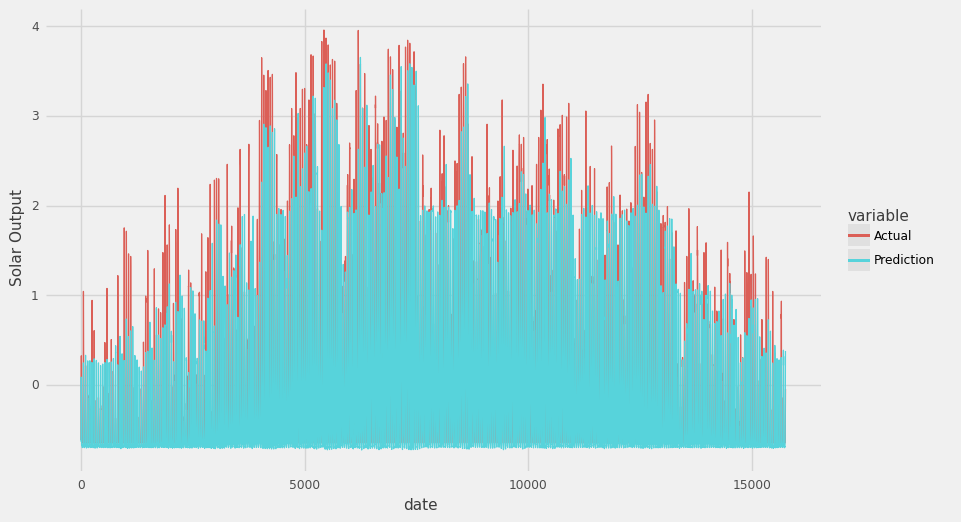

<ggplot: (8739574602209)>


In [91]:
actualPred(y_test.reshape(-1, ), test_pred.reshape(-1))

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


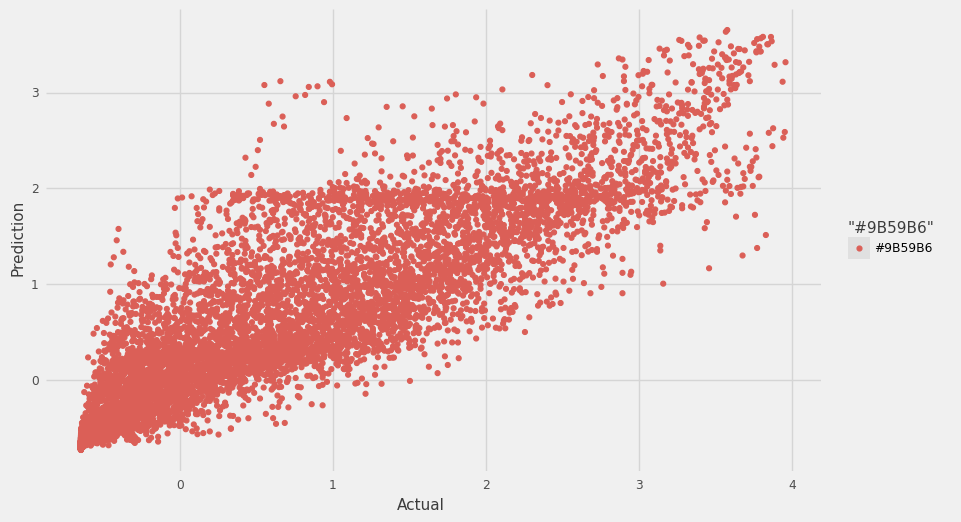

<ggplot: (8739574679602)>


In [90]:
scatter(y_test.reshape(-1, ), test_pred.reshape(-1))

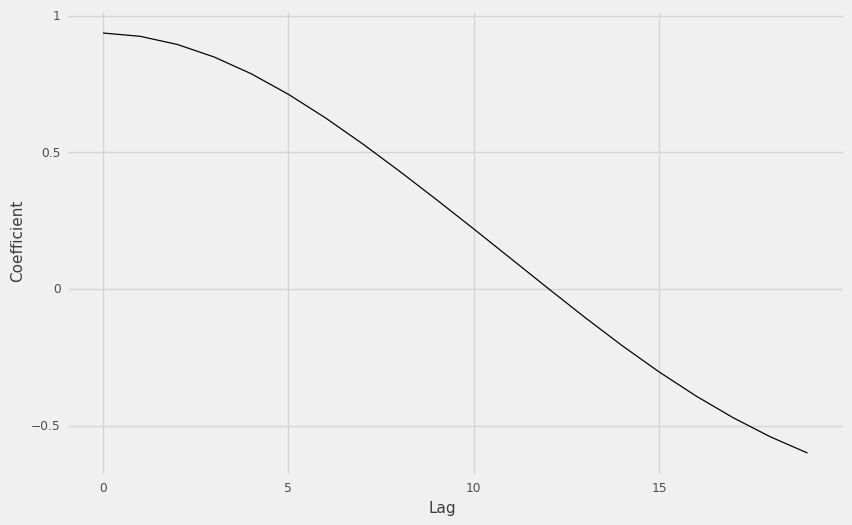

<ggplot: (-9223363297289213822)>


In [89]:
get_lag_corr(y_test.reshape(-1, ), test_pred.reshape(-1), num_lags=20)

Now we try to predict with the model on the next 24 hours. At the moment, out training data has values for up until the 21/11 11.30. Meaning we need to predict for starting at 12.30 on the 11th up until 11.30 on the 22nd. 

For this, t_zero would be 48 time steps before, 12.30 on the 1st. 

Window of 15 prior to t_zero. We already have this data. 

In [40]:
build_forecast_df = build_features_forecast(df.energy, features_request, include_tzero=True)
scaled_features_forecast = scaler_features.transform(build_forecast_df.tail(48))
pred = model.predict(scaled_features_forecast[:, :-1])

In [41]:
from datetime import timedelta 

In [42]:
range = pd.date_range(start=build_df.index[-1]+timedelta(minutes=30), 
              end=build_df.index[-1]+timedelta(hours=24), 
              freq="30T")
range.freq = None
range = range.to_list()

In [43]:
pred = scaler_label.inverse_transform(pred)

In [44]:
### Get actual values
new_data = pvl.between(pytz.utc.localize(range[0]), pytz.utc.localize(range[-1]))
new_data = np.array([x[2] for x in new_data])

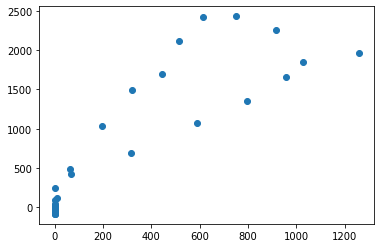

In [45]:
plt.scatter(new_data, pred)

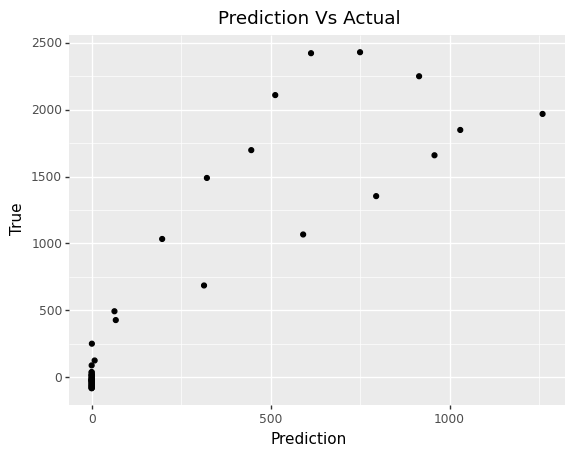

<ggplot: (-9223363297282149523)>

In [46]:
p = ggplot(aes(x='prediction', y='true'), pd.DataFrame({"prediction": new_data, 
                                                  "true": pred.reshape(-1)}))
p + geom_point() + xlab("Prediction") + ylab("True") + ggtitle("Prediction Vs Actual")

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


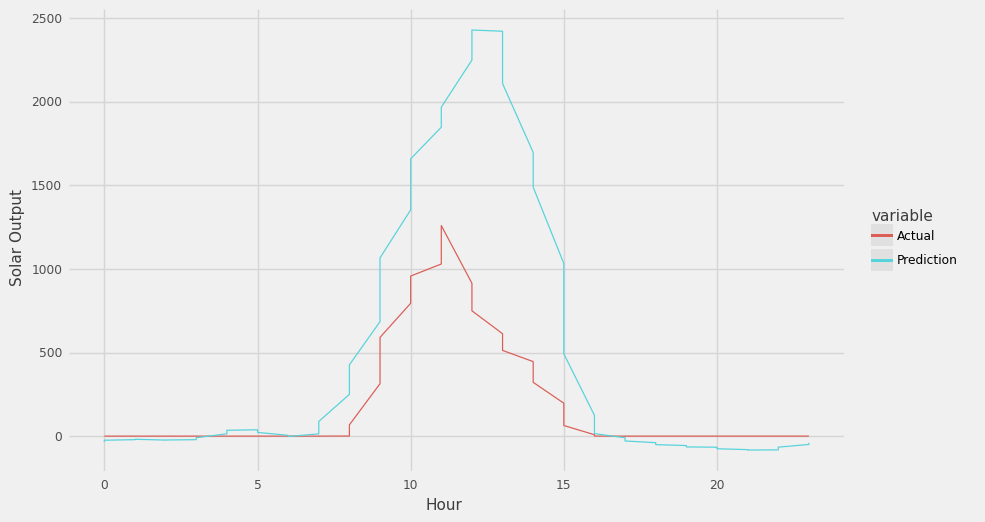

<ggplot: (-9223363297275341820)>

In [47]:
datum = pd.DataFrame({
        "date": build_forecast_df.tail(48).index.hour,
        "Actual":new_data, 
        "Prediction":pred.reshape(-1)
    })

datum = pd.melt(datum, id_vars=['date'], value_vars=['Actual', 'Prediction']) 

p = (
    
    ggplot(datum, aes(x='date'))
    + geom_line(aes(y='value', color='variable')) # line plot
    + labs(x='Hour', y='Solar Output')
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


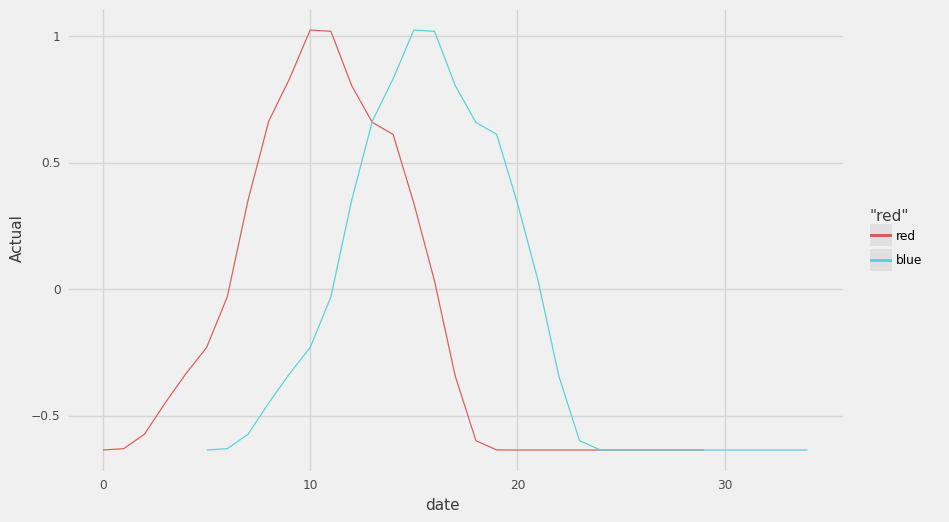

<ggplot: (8751432373768)>

In [143]:
datum = pd.DataFrame({
        "date": np.arange(30),
        "datum": np.arange(30) + 5,
        "Actual": y_test[40:70].reshape(-1), 
        "Prediction": y_test[40:70].reshape(-1)
    })

p = (
    
    ggplot(datum)
    + geom_line(aes(x='date', y="Actual", color='"red"'))
    + geom_line(aes(x='datum', y="Prediction", color='"blue"'))
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p